## Business Problem


<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

# Dataset Information

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.


## Load Libraries 

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

# 1.1 Reading Data

In [2]:

data  = pd.read_csv('../input/project-resources/preprocessed_data.csv')
print("Number of data points in train data", data.shape)
print('-'*50)
print("The attributes of data :", data.columns.values)

Number of data points in train data (109248, 9)
--------------------------------------------------
The attributes of data : ['school_state' 'teacher_prefix' 'project_grade_category'
 'teacher_number_of_previously_posted_projects' 'project_is_approved'
 'clean_categories' 'clean_subcategories' 'essay' 'price']


## Categorical Feature Transformation 


### 1.2 School state


In [3]:
vectorizer = CountVectorizer(binary=True)
school_features_ohe = vectorizer.fit_transform(data['school_state'].values)
print("Shape of matrix after one hot encodig school state ",school_features_ohe.shape)

Shape of matrix after one hot encodig school state  (109248, 51)


## 1.3 Teacher_prefix

In [4]:

teacher_prefix_ohe = vectorizer.fit_transform(data['teacher_prefix'].values)
print("Shape of matrix after one hot encodig teacher prefix ",teacher_prefix_ohe.shape)

Shape of matrix after one hot encodig teacher prefix  (109248, 5)


## 1.4 project grade category

In [5]:

grade_category_ohe = vectorizer.fit_transform(data['project_grade_category'].values)
print("Shape of matrix after one hot encodig project grade category  ",grade_category_ohe.shape)

Shape of matrix after one hot encodig project grade category   (109248, 4)


## 1.5 categories

In [6]:

categories_ohe = vectorizer.fit_transform(data['clean_categories'].values)
print("Shape of matrix after one hot encodig categories  ",categories_ohe.shape)

Shape of matrix after one hot encodig categories   (109248, 9)


## 1.6 sub categories

In [7]:

sub_categories_ohe = vectorizer.fit_transform(data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig sub categories  ",sub_categories_ohe.shape)

Shape of matrix after one hot encodig sub categories   (109248, 30)


## 2 Numerical Feature Transformation

## 2.1 Price Transformation

In [8]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(data['price'].values.reshape(-1, 1))
# standard_prices=scaler.transform(data['price'].values.reshape(-1, 1) )

# Decision Tree not affected by feature variance so not using scaling
standard_prices = data['price'].values.reshape(-1,1)
print("Shape of matrix after price transformation  ",standard_prices.shape)

Shape of matrix after price transformation   (109248, 1)


## 2.2 teacher_number_of_previously_posted_projects Transformation


In [9]:
# scaler.fit(data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
# standard_teachers_number=scaler.transform(data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1) )
standard_teachers_number = data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
print("Shape of matrix after teachers number posted project transformation  ",standard_teachers_number.shape)

Shape of matrix after teachers number posted project transformation   (109248, 1)


# 3. Vectorizing Text data

## 3.1 TFIDF vectorizer

In [10]:
preprocessed_essays = data['essay'].values


tf_idf_vectorizer = TfidfVectorizer(min_df=10)
text_tfidf_eassy = tf_idf_vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf_eassy.shape)

Shape of matrix after one hot encodig  (109248, 16623)


## 3.2 TfIdf weighted W2V

In [11]:
def loadGloveModel(filepath):
    
    print("Loading Glove file")
    model =dict()
    with open(filepath,'r', encoding="utf8") as f:
        for line in tqdm(f):
            # line format : word    d1        d2      d3 .......................d300
            #              we     0.039578 -0.017306 0.15328 ................ 0.083129 
            splitline = line.split()
            word = splitline[0]
            embeddings = np.array([float(val) for val in splitline[1:]])
            model[word]=embeddings
            
        print("Model Loaded : Total words : {} ".format(len(model)))
    return model

# glove_model = loadGloveModel('../input/glove42b300dtxt/glove.42B.300d.txt')

In [12]:
# load glove_vectors
glove_model=None
with open("../input/project-resources/glove_vectors",'rb') as f:
    glove_model = pickle.load(f)

In [13]:

tfidf_eassy_model = TfidfVectorizer()
tfidf_eassy_model.fit(preprocessed_essays)
dictionary_eassy = dict(zip(tfidf_eassy_model.get_feature_names(), list(tfidf_eassy_model.idf_)))
tfidf_words_eassy = set(tfidf_eassy_model.get_feature_names())

In [14]:
tfidf_w2v_vectors_eassy=[]

for eassy in tqdm(preprocessed_essays):
    vector = np.zeros(300)
    tf_idf_weight =0
    for word in eassy.split(" "):
        if word in glove_model and word in  tfidf_words_eassy:
            word_vec = glove_model[word]
            word_idf = dictionary_eassy[word]
            word_tf = eassy.count(word)/len(eassy.split())
            word_tf_idf = word_tf * word_idf
            vector+= (word_vec * word_tf_idf)
            tf_idf_weight+=word_tf_idf
            
            
    if tf_idf_weight !=0:
        vector/=tf_idf_weight
    tfidf_w2v_vectors_eassy.append(vector)
    


100%|██████████| 109248/109248 [04:52<00:00, 373.26it/s]


## Analyse Eassy Sentiments

In [15]:
eassy_sentiments = {'neg':[],'neu':[],'pos':[],'compound':[]}

                    
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

for eassy in tqdm(preprocessed_essays):
    sentiment_score = sid.polarity_scores(eassy)
    for key in sentiment_score.keys():
        eassy_sentiments[key].append(sentiment_score[key])

neg_eassy_sentiments = np.array(eassy_sentiments['neg']).reshape(-1,1).astype(np.float16)
pos_eassy_sentiments = np.array(eassy_sentiments['pos']).reshape(-1,1).astype(np.float16)
neu_eassy_sentiments =  np.array(eassy_sentiments['neu']).reshape(-1,1).astype(np.float16)
compound_eassy_sentiments =  np.array(eassy_sentiments['compound']).reshape(-1,1).astype(np.float16)

100%|██████████| 109248/109248 [04:23<00:00, 414.10it/s]


## Downcasting Column Data Type

In [16]:
school_features_ohe = school_features_ohe.astype(np.int8)
teacher_prefix_ohe = teacher_prefix_ohe.astype(np.int8)
grade_category_ohe = grade_category_ohe.astype(np.int8)
categories_ohe = categories_ohe.astype(np.int8)
sub_categories_ohe = sub_categories_ohe.astype(np.int8)
standard_prices = standard_prices.astype(np.float32)
standard_teachers_number = standard_teachers_number.astype(np.float32)
text_tfidf_eassy = text_tfidf_eassy.astype(np.float16)

print("School feature shape",school_features_ohe.shape)
print("Teacher feature shape",teacher_prefix_ohe.shape)
print("Grade category feature shape",grade_category_ohe.shape)
print("Categories feature shape", categories_ohe.shape)
print("subcategory feature shape",sub_categories_ohe.shape)
print("text_tfidf_eassy shape", text_tfidf_eassy.shape)
print("standard_prices shape", standard_prices.shape)
print("standard_teachers_number shape ", standard_teachers_number.shape)
print("Negative sentiment score shape", neg_eassy_sentiments.shape)
print("Positive sentiment score shape", pos_eassy_sentiments.shape)
print("Neutral sentiment score shape", neu_eassy_sentiments.shape)
print("compound sentiment score shape", compound_eassy_sentiments.shape)


School feature shape (109248, 51)
Teacher feature shape (109248, 5)
Grade category feature shape (109248, 4)
Categories feature shape (109248, 9)
subcategory feature shape (109248, 30)
text_tfidf_eassy shape (109248, 16623)
standard_prices shape (109248, 1)
standard_teachers_number shape  (109248, 1)
Negative sentiment score shape (109248, 1)
Positive sentiment score shape (109248, 1)
Neutral sentiment score shape (109248, 1)
compound sentiment score shape (109248, 1)


## 4.1 Experiment 1 :  TfIdf features for eassy and run Decision Tree

In [17]:
orig_index = [i for i in range(len(standard_prices))]


In [18]:
from scipy.sparse import hstack
X = hstack(
    (
    school_features_ohe,
    categories_ohe,
    teacher_prefix_ohe,
    grade_category_ohe,
    sub_categories_ohe,
    text_tfidf_eassy,
    standard_prices,
    standard_teachers_number,
    neg_eassy_sentiments,
    pos_eassy_sentiments,
    neu_eassy_sentiments,
    compound_eassy_sentiments,
    np.array(orig_index).reshape(-1,1).astype(np.int32)
    ))

X=X.astype(np.float32)

Y = data['project_is_approved']
Y=Y.to_numpy()



### 4.1.2 Train Test split

In [19]:

X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=41)

print("Training Data shape ", X_train_orig.shape, y_train.shape)
print("Testing Data shape ", X_test_orig.shape, y_test.shape)

Training Data shape  (87398, 16729) (87398,)
Testing Data shape  (21850, 16729) (21850,)


### 4.1.3 GridSearch Cross Validation

In [20]:
depth_param = [1,3,10,30]
min_sample_param=[5,50,100,500]

model_history={
    'depth':[],
    'min_sample':[],
    'train_auc':[],
    'validation_auc':[],
    'fold':[]
}

tuned_parameters = [{"max_depth": depth_param,"min_samples_split":min_sample_param}]
n_folds=5

In [21]:
# Custom Loop for Cross fold validation
# # custom Loop
# k_fold = KFold(4) 
# # X_train = X_train.toarray()
# for k, (train, test) in enumerate(k_fold.split(X_train, y_train)):
#     print("Fold {}",k)
#     for depth in depth_param:
#         for min_samp in tqdm(min_sample_param):
#             dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=min_samp,random_state=0)
#             # fit on Train set
#             dt_clf.fit(X_train[train], y_train[train])
#             # auc score for train data
#             y_train_pred=dt_clf.predict_prob(X_train[train])
#             # roc curve for train data
#             fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train[train], y_train_pred)
#             # auc score for train data
#             auc_train = auc(fpr_train,tpr_train)
#             model_history['depth'].append(depth)
#             model_history['min_sample'].append(min_samp)
#             model_history['train_auc'].append(auc_train)
#             model_history['fold'].append(k)
            
            
            
#             # check on validation
#             # auc score for Validation data
#             y_valid_pred=dt_clf.predict_prob(X_train[test])
#             # roc curve for Validation data
#             fpr_valid, tpr_valid, thresholds = metrics.roc_curve(y_train[test], y_valid_pred)
#             # auc score for Validation data
#             auc_valid = auc(fpr_valid,tpr_valid)
#             model_history['validation_auc']..append(auc_valid)
            
#             print("Fold {}, Depth {}, min_sample {}, train_auc {}, validation_auc {}".format(
#                 k,depth, min_samp, auc_train, auc_valid
#             ))
            


In [22]:
dt_clf = DecisionTreeClassifier(random_state=100)
# hyperparameter tuninng with GridSearchCV
clf = GridSearchCV(dt_clf, tuned_parameters, cv=n_folds, refit=False,scoring='roc_auc', return_train_score=True)
clf.fit(X_train_orig[:, :-1], y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid=[{'max_depth': [1, 3, 10, 30],
                          'min_samples_split': [5, 50, 100, 500]}],
             refit=False, return_train_score=True, scoring='roc_auc')

In [23]:
score = clf.cv_results_

print("Best Hyper parameter ", clf.best_params_)
print("Best Score : ", clf.best_score_)



Best Hyper parameter  {'max_depth': 10, 'min_samples_split': 500}
Best Score :  0.6475206057300846


### 4.1.4 Training on Best Hyper paramter from cross validation

In [24]:
# use hyper parameter choice from gridsearch results
best_dt_clf = DecisionTreeClassifier(random_state=110, 
                                     max_depth=clf.best_params_['max_depth'],
                                     min_samples_split=clf.best_params_['min_samples_split'])
best_dt_clf.fit(X_train_orig[:,:-1], y_train)


# performance on test data
y_test_pred=best_dt_clf.predict_proba(X_test_orig[:,:-1])
# get fpr and tpr
fpr, tpr, thresholds = metrics.roc_curve(y_test, np.max(y_test_pred, axis=1))

print("Performance of Best Model : Auc score on Xtest",auc(fpr,tpr))

# performance on train data
y_train_pred=best_dt_clf.predict_proba(X_train_orig[:,:-1])

fpr, tpr, thresholds = metrics.roc_curve(y_train, np.max(y_train_pred, axis=1))

print("Performance of Best Model : Auc score on Xtrain",auc(fpr,tpr))


Performance of Best Model : Auc score on Xtest 0.6551174030033807
Performance of Best Model : Auc score on Xtrain 0.6751487812012734


### 4.1.5 Heatmaps Hyperparameter choice vs Auc score

In [25]:
depth_list = clf.cv_results_['param_max_depth']
min_sample_split_list =  clf.cv_results_['param_min_samples_split']
split0_score = clf.cv_results_['split0_test_score']
split1_score = clf.cv_results_['split1_test_score']
split2_score = clf.cv_results_['split2_test_score']
split3_score = clf.cv_results_['split3_test_score']
split4_score = clf.cv_results_['split4_test_score']
avg_cv_score_across_folds = np.mean(np.vstack((split0_score, split1_score,split2_score,split3_score,split4_score)).T, axis=1)





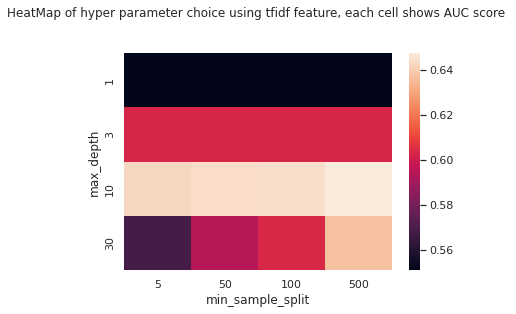

In [26]:
depth_list = np.array(depth_list)
min_sample_split_list = np.array(min_sample_split_list)
# avg_cv_score_across_folds
params_auc = pd.DataFrame({
                            'max_depth':depth_list, 
                           'min_sample_split':min_sample_split_list,
                            'auc_score':avg_cv_score_across_folds})

# pivoting
result = params_auc.pivot(index='max_depth',columns='min_sample_split',values='auc_score')
import seaborn as sns
sns.set_theme()
ax = sns.heatmap(result)
ax.set_title('HeatMap of hyper parameter choice using tfidf feature, each cell shows AUC score \n\n');


### 4.1.6 Roc-Auc curve

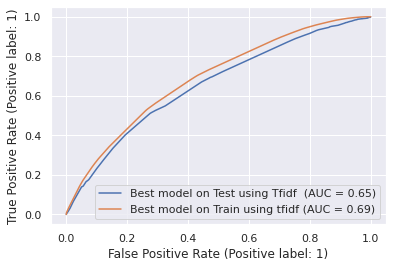

In [27]:


plt1 = metrics.plot_roc_curve(best_dt_clf, X_test_orig[:,:-1], y_test,name="Best model on Test using Tfidf ") 
plt2 = metrics.plot_roc_curve(best_dt_clf, X_train_orig[:,:-1], y_train,ax=plt1.ax_, name="Best model on Train using tfidf")

plt.show()



### 4.1.7 Plot confusion Matrix

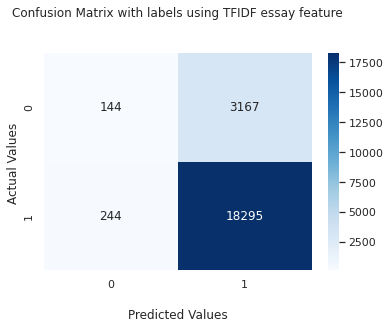

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_test_pred = best_dt_clf.predict(X_test_orig[:,:-1])
cm= confusion_matrix(  y_test,y_test_pred) 
# cm_display = ConfusionMatrixDisplay(cm).plot()
ax = sns.heatmap(cm, annot=True, cmap='Blues',fmt="d")
ax.set_title('Confusion Matrix with labels using TFIDF essay feature\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
## Display the visualization of the Confusion Matrix.
plt.show()

### 4.1.8 False Positive Analysis



In [29]:
index_list=[id for id in range(len(y_test))]
False_positive_indexes = np.array(index_list)[((y_test == 0 ) & (y_test_pred==1))]
print(len(False_positive_indexes), False_positive_indexes[-5:])

3167 [21818 21825 21831 21840 21844]


### 4.1.9 False positive data points : Word cloud 

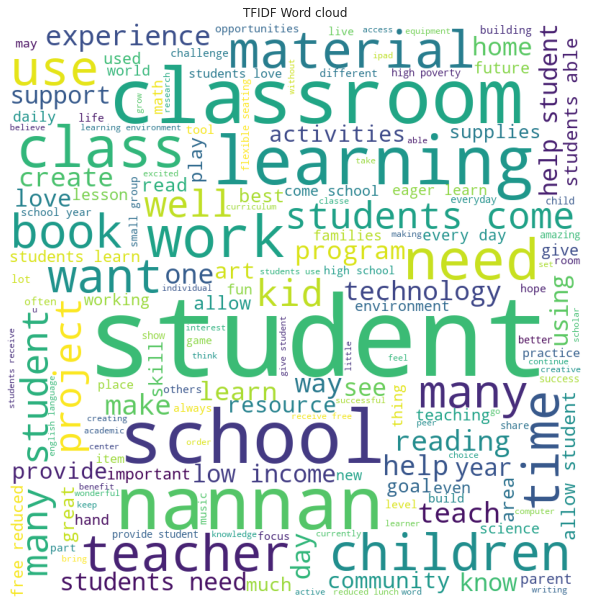

In [30]:
# False positive eassy
orig_index_of_essay = X_test_orig[False_positive_indexes,-1]
# get text of all false positive essay
fp_essay = preprocessed_essays[orig_index_of_essay.toarray().astype(np.int32)[:,0]]




combined_essay = ''

# iterate through every eassy
for essay in fp_essay:
    # split the value
    tokens = essay.split()
    combined_essay += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(combined_essay)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("TFIDF Word cloud")

plt.show()

### 4.1.10 Price plot for False positive data points

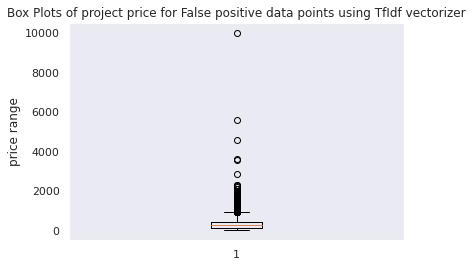

In [31]:

fp_price = data['price'][orig_index_of_essay.toarray().astype(np.int32)[:,0]]
# false_positive_price = data['price'][False_positive_indexes]
plt.boxplot([fp_price])
plt.title('Box Plots of project price for False positive data points using TfIdf vectorizer')

plt.ylabel('price range')
plt.grid()
plt.show()


### 4.1.11 Teachers project count plot for False positive data points

<AxesSubplot:xlabel='teacher_number_of_previously_posted_projects', ylabel='Density'>

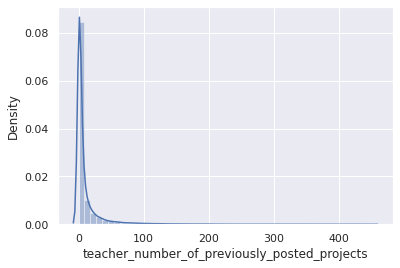

In [32]:
False_positive_teacher_posted_project = data['teacher_number_of_previously_posted_projects']
False_positive_teacher_posted_project = False_positive_teacher_posted_project
[orig_index_of_essay.toarray().astype(np.int32)[:,0]]
sns.distplot(False_positive_teacher_posted_project, hist=True)

## 4.2 Experiment 1 :  TfIdf weighted W2V features for eassy and run Decision Tree

### 4.2.1 Prepare Data

In [33]:
tfidf_w2v_vectors_eassy=np.array(tfidf_w2v_vectors_eassy).astype(np.float16)
orig_index = [i for i in range(len(standard_prices))]

In [34]:
from scipy.sparse import hstack
X = hstack(
    (
    school_features_ohe,
    categories_ohe,
    teacher_prefix_ohe,
    grade_category_ohe,
    sub_categories_ohe,
    tfidf_w2v_vectors_eassy,
    standard_prices,
    standard_teachers_number,
    neg_eassy_sentiments,
    pos_eassy_sentiments,
    neu_eassy_sentiments,
    compound_eassy_sentiments,
    np.array(orig_index).reshape(-1,1).astype(np.int32)
    ))

X=X.astype(np.float32)

Y = data['project_is_approved']
Y=Y.to_numpy()



### 4.2.2 Test Train split

In [35]:

X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=41)

print("Training Data shape ", X_train_orig.shape, y_train.shape)
print("Testing Data shape ", X_test_orig.shape, y_test.shape)

Training Data shape  (87398, 406) (87398,)
Testing Data shape  (21850, 406) (21850,)


### 4.2.3 GridSearch Cross Validation

In [36]:
depth_param = [1,3,10,30]
min_sample_param=[5,50,100,500]

model_history={
    'depth':[],
    'min_sample':[],
    'train_auc':[],
    'validation_auc':[],
    'fold':[]
}

tuned_parameters = [{"max_depth": depth_param,"min_samples_split":min_sample_param}]
n_folds=5

In [37]:
dt_clf = DecisionTreeClassifier(random_state=1001)
# hyperparameter tuninng with GridSearchCV
clf = GridSearchCV(dt_clf, tuned_parameters, cv=n_folds, refit=False,scoring='roc_auc', return_train_score=True)
clf.fit(X_train_orig[:, :-1], y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1001),
             param_grid=[{'max_depth': [1, 3, 10, 30],
                          'min_samples_split': [5, 50, 100, 500]}],
             refit=False, return_train_score=True, scoring='roc_auc')

In [38]:
score = clf.cv_results_

print("Best Hyper parameter ", clf.best_params_)
print("Best Score : ", clf.best_score_)



Best Hyper parameter  {'max_depth': 10, 'min_samples_split': 500}
Best Score :  0.6347657709596282


### 4.2.4 Training on Best Hyper paramter from cross validation

In [39]:
# use hyper parameter choice from gridsearch results
best_dt_clf = DecisionTreeClassifier(random_state=110,
                                     max_depth=clf.best_params_['max_depth'],
                                     min_samples_split=clf.best_params_['min_samples_split'])
best_dt_clf.fit(X_train_orig[:,:-1], y_train)


# performance on test data
y_test_pred=best_dt_clf.predict_proba(X_test_orig[:,:-1])
# get fpr and tpr
fpr, tpr, thresholds = metrics.roc_curve(y_test, np.max(y_test_pred, axis=1))

print("Performance of Best Model : Auc score on Xtest",auc(fpr,tpr))

# performance on train data
y_train_pred=best_dt_clf.predict_proba(X_train_orig[:,:-1])

fpr, tpr, thresholds = metrics.roc_curve(y_train, np.max(y_train_pred, axis=1))

print("Performance of Best Model : Auc score on Xtrain",auc(fpr,tpr))


Performance of Best Model : Auc score on Xtest 0.6415877853651397
Performance of Best Model : Auc score on Xtrain 0.7112259685567212


### 4.2.5 Heatmaps Hyperparameter choice vs Auc score

In [40]:
depth_list = clf.cv_results_['param_max_depth']
min_sample_split_list =  clf.cv_results_['param_min_samples_split']
split0_score = clf.cv_results_['split0_test_score']
split1_score = clf.cv_results_['split1_test_score']
split2_score = clf.cv_results_['split2_test_score']
split3_score = clf.cv_results_['split3_test_score']
split4_score = clf.cv_results_['split4_test_score']
avg_cv_score_across_folds = np.mean(np.vstack((split0_score, split1_score,split2_score,split3_score,split4_score)).T, axis=1)





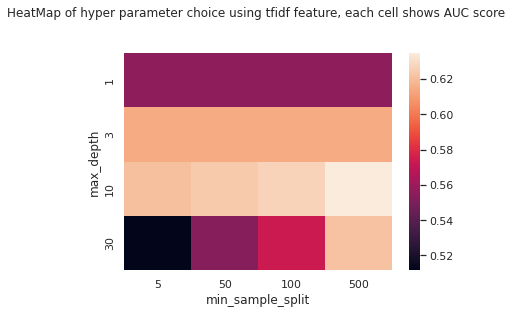

In [41]:
depth_list = np.array(depth_list)
min_sample_split_list = np.array(min_sample_split_list)
# avg_cv_score_across_folds
params_auc = pd.DataFrame({
                            'max_depth':depth_list, 
                           'min_sample_split':min_sample_split_list,
                            'auc_score':avg_cv_score_across_folds})

# pivoting
result = params_auc.pivot(index='max_depth',columns='min_sample_split',values='auc_score')
import seaborn as sns
sns.set_theme()
ax = sns.heatmap(result)
ax.set_title('HeatMap of hyper parameter choice using tfidf feature, each cell shows AUC score \n\n');


### 4.2.6 Roc-Auc curve

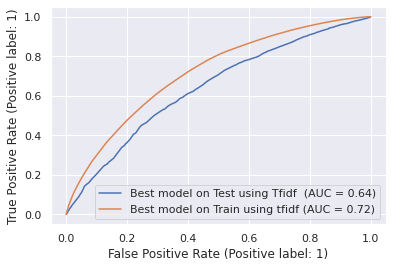

In [42]:


plt1 = metrics.plot_roc_curve(best_dt_clf, X_test_orig[:,:-1], y_test,name="Best model on Test using Tfidf ") 
plt2 = metrics.plot_roc_curve(best_dt_clf, X_train_orig[:,:-1], y_train,ax=plt1.ax_, name="Best model on Train using tfidf")

plt.show()



### 4.2.7 Plot Confusion Matrix

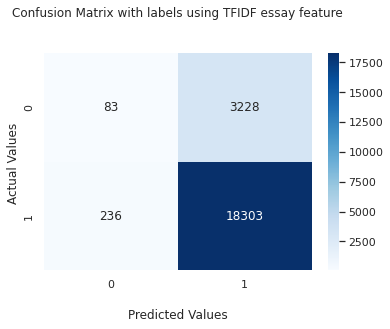

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_test_pred = best_dt_clf.predict(X_test_orig[:,:-1])
cm= confusion_matrix(  y_test,y_test_pred) 
# cm_display = ConfusionMatrixDisplay(cm).plot()
ax = sns.heatmap(cm, annot=True, cmap='Blues',fmt="d")
ax.set_title('Confusion Matrix with labels using TFIDF essay feature\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
## Display the visualization of the Confusion Matrix.
plt.show()

### 4.2.8 False Positive Analysis



In [44]:
index_list=[id for id in range(len(y_test))]
False_positive_indexes = np.array(index_list)[((y_test == 0 ) & (y_test_pred==1))]
print(len(False_positive_indexes), False_positive_indexes[-5:])

3228 [21825 21831 21838 21840 21844]


### 4.2.9 False Positive Data Point : Word Cloud

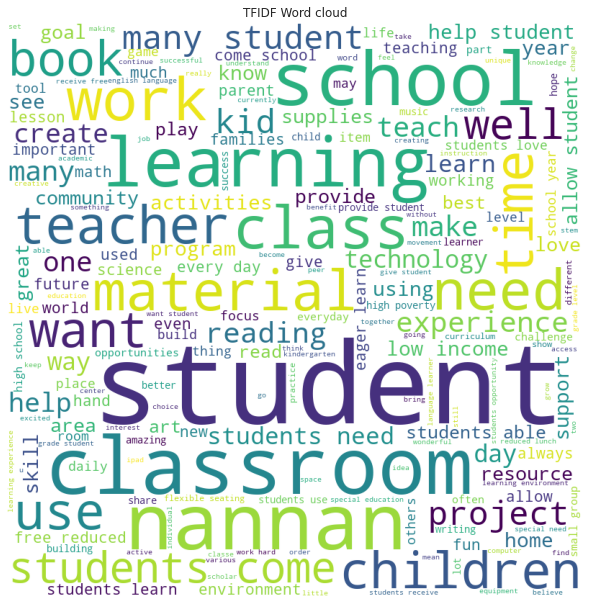

In [45]:
# False positive eassy
orig_index_of_essay = X_test_orig[False_positive_indexes,-1]
# get text of all false positive essay
fp_essay = preprocessed_essays[orig_index_of_essay.toarray().astype(np.int32)[:,0]]




combined_essay = ''

# iterate through every eassy
for essay in fp_essay:
    # split the value
    tokens = essay.split()
    combined_essay += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(combined_essay)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("TFIDF Word cloud")

plt.show()

### 4.2.10 Price Plot for False Positive Analysis

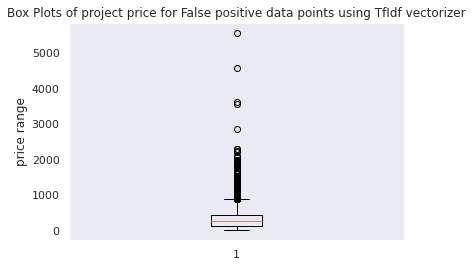

In [46]:

fp_price = data['price'][orig_index_of_essay.toarray().astype(np.int32)[:,0]]
# false_positive_price = data['price'][False_positive_indexes]
plt.boxplot([fp_price])
plt.title('Box Plots of project price for False positive data points using TfIdf vectorizer')

plt.ylabel('price range')
plt.grid()
plt.show()


### 4.2.11 Teachers Past Project proposal for False positive

<AxesSubplot:xlabel='teacher_number_of_previously_posted_projects', ylabel='Density'>

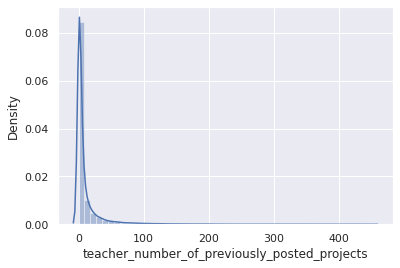

In [47]:
False_positive_teacher_posted_project = data['teacher_number_of_previously_posted_projects']
False_positive_teacher_posted_project = False_positive_teacher_posted_project
[orig_index_of_essay.toarray().astype(np.int32)[:,0]]
sns.distplot(False_positive_teacher_posted_project, hist=True)